In [50]:
import os
import pandas as pd
from util import set_seed

RANDOM_STATE = 42
set_seed(RANDOM_STATE)
current_dir = os.getcwd()
final_path = os.path.join(current_dir, '..', 'data', 'final', 'final.csv')

final_df = pd.read_csv(final_path)

### Przygotowanie danych

In [51]:
from util import prepare_final

normalized_df = prepare_final(final_df.copy())

normalized_df.head()

,premium_user,popularity_mean,popularity_std,popularity_mode,popularity_median,popularity_min,popularity_max,duration_ms_mean,duration_ms_std,duration_ms_mode,...,q,r,s,t,u,v,w,x,y,z
0,False,-0.997069,-0.995204,-0.973336,-0.996697,-0.319064,-0.994713,-1.059379,-0.409611,-0.825471,...,0,1,0,1,1,0,1,0,0,0
1,False,1.066575,0.740434,1.503039,1.097880,2.270742,0.713372,0.661699,-0.043242,1.674050,...,0,1,0,1,0,1,1,0,0,0
2,False,-0.997069,-0.995204,-0.973336,-0.996697,-0.319064,-0.994713,-1.429353,-0.963033,-0.008440,...,0,1,1,0,1,0,0,0,0,0
3,False,-0.997069,-0.995204,-0.973336,-0.996697,-0.319064,-0.994713,-1.192440,-0.607767,-0.537427,...,0,1,0,1,1,1,1,0,1,0
4,False,1.056186,1.104850,1.382240,1.041270,0.544205,0.968310,0.678373,-0.770022,0.873527,...,0,1,1,1,1,0,0,0,0,0


In [52]:
from sklearn.model_selection import train_test_split

X = normalized_df.drop('premium_user', axis=1)
y = normalized_df['premium_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

### Klasyfikator Random Forest
Uczenie

In [53]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

clf = RandomForestClassifier(n_estimators=1000, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

Accuracy: 0.81
ROC AUC: 0.87
Precision: 0.81
Recall: 0.70
F1 Score: 0.75


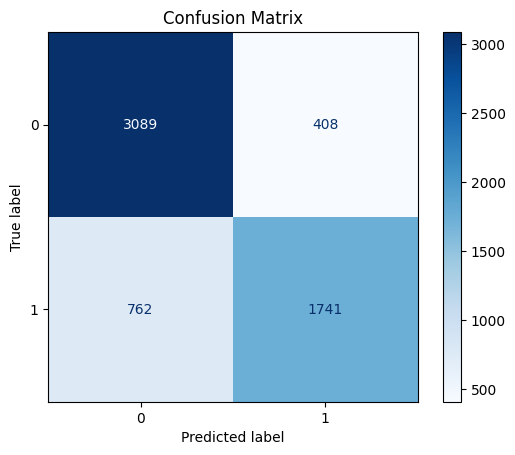

In [54]:
from util import show_metrics

show_metrics(y_test, y_pred, y_pred_proba)

Selekcja atrybutów

In [55]:
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

n = 30
selected_features = X_train.columns[indices][:n]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected.head()

,skip_play_ratio,timestamp_diff_median,daily_activity_max,weekly_activity_max,skip_count,like_play_ratio,like_count,daily_activity,weekly_activity,monthly_activity,...,release_year_mean,energy_median,unique_track_count,play_count,unique_artist_count,valence_mean,release_year_std,instrumentalness_mean,energy_mean,speechiness_mean
21753,1.148967,-1.064172,-0.082970,-0.306944,0.248699,0.893592,0.008853,0.633184,0.356659,0.342104,...,1.163450,1.167738,-0.796238,-0.890123,-0.636550,-1.284575,-0.977819,-0.541855,1.070645,-0.778886
251,1.276084,-1.209049,0.725624,0.305384,0.699199,0.732191,0.263062,1.812973,1.451364,0.858345,...,0.960840,0.880514,-0.272982,-0.425848,-0.423377,-0.771339,-0.916620,-0.916972,0.898991,-1.079239
22941,1.310879,-1.095991,0.850024,0.399588,1.049588,0.870949,0.655929,1.280262,0.957071,0.443947,...,0.971909,1.253401,0.168194,-0.034400,0.024288,-0.950466,-1.013101,-1.161595,1.186216,-0.768272
618,1.241430,-1.324965,0.601225,2.001061,1.487574,0.982545,1.233676,0.057735,0.921884,0.981529,...,0.951334,1.001450,0.794049,0.575530,0.962253,-0.809741,-1.054808,-1.099546,0.958725,-0.927810
17090,-0.886245,0.955687,-0.953764,-0.966375,-0.902578,-1.072747,-1.077310,-0.093952,-0.318037,-0.625057,...,-0.917871,-0.893220,-1.360533,-1.317985,-1.382658,1.716267,1.168762,0.942475,-0.933159,1.045649


In [56]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

clf_temp = RandomForestClassifier(random_state=RANDOM_STATE)

random_search = RandomizedSearchCV(
    estimator=clf_temp,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42,
    scoring='roc_auc'
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
Best cross-validation score:  0.8776635615365838


In [57]:
clf_selected = RandomForestClassifier(n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features='sqrt', max_depth=30, bootstrap=True, random_state=RANDOM_STATE)
clf_selected.fit(X_train_selected, y_train)

y_pred_selected = clf_selected.predict(X_test_selected)
y_pred_proba_selected = clf_selected.predict_proba(X_test_selected)[:, 1]

Accuracy: 0.81
ROC AUC: 0.87
Precision: 0.81
Recall: 0.70
F1 Score: 0.75


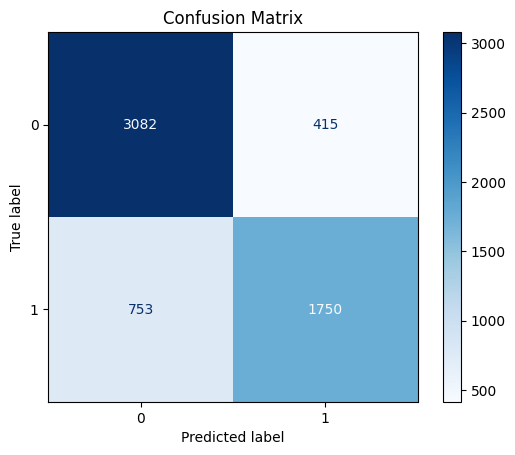

In [58]:
show_metrics(y_test, y_pred_selected, y_pred_proba_selected)

In [59]:
selected_path = os.path.join(current_dir, '..', 'data', 'final', 'selected.csv')
X_selected = X[selected_features]
X_selected['user_id'] = final_df['user_id'].copy()
X_selected.to_csv(selected_path, index=False)
X_selected.drop(columns=['user_id'], inplace=True)

C:\Users\pcs\AppData\Local\Temp\ipykernel_10336\2921439878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected['user_id'] = final_df['user_id'].copy()
C:\Users\pcs\AppData\Local\Temp\ipykernel_10336\2921439878.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_selected.drop(columns=['user_id'], inplace=True)


Index(['skip_play_ratio', 'timestamp_diff_median', 'daily_activity_max',
       'weekly_activity_max', 'skip_count', 'like_play_ratio', 'like_count',
       'daily_activity', 'weekly_activity', 'monthly_activity',
       'timestamp_diff_std', 'timestamp_diff_mean', 'session_count',
       'danceability_mean', 'danceability_median', 'city_frequency',
       'duration_ms_median', 'monthly_activity_max', 'skip_like_ratio',
       'explicit_count', 'release_year_mean', 'energy_median',
       'unique_track_count', 'play_count', 'unique_artist_count',
       'valence_mean', 'release_year_std', 'instrumentalness_mean',
       'energy_mean', 'speechiness_mean'],
      dtype='object')


<Axes: >

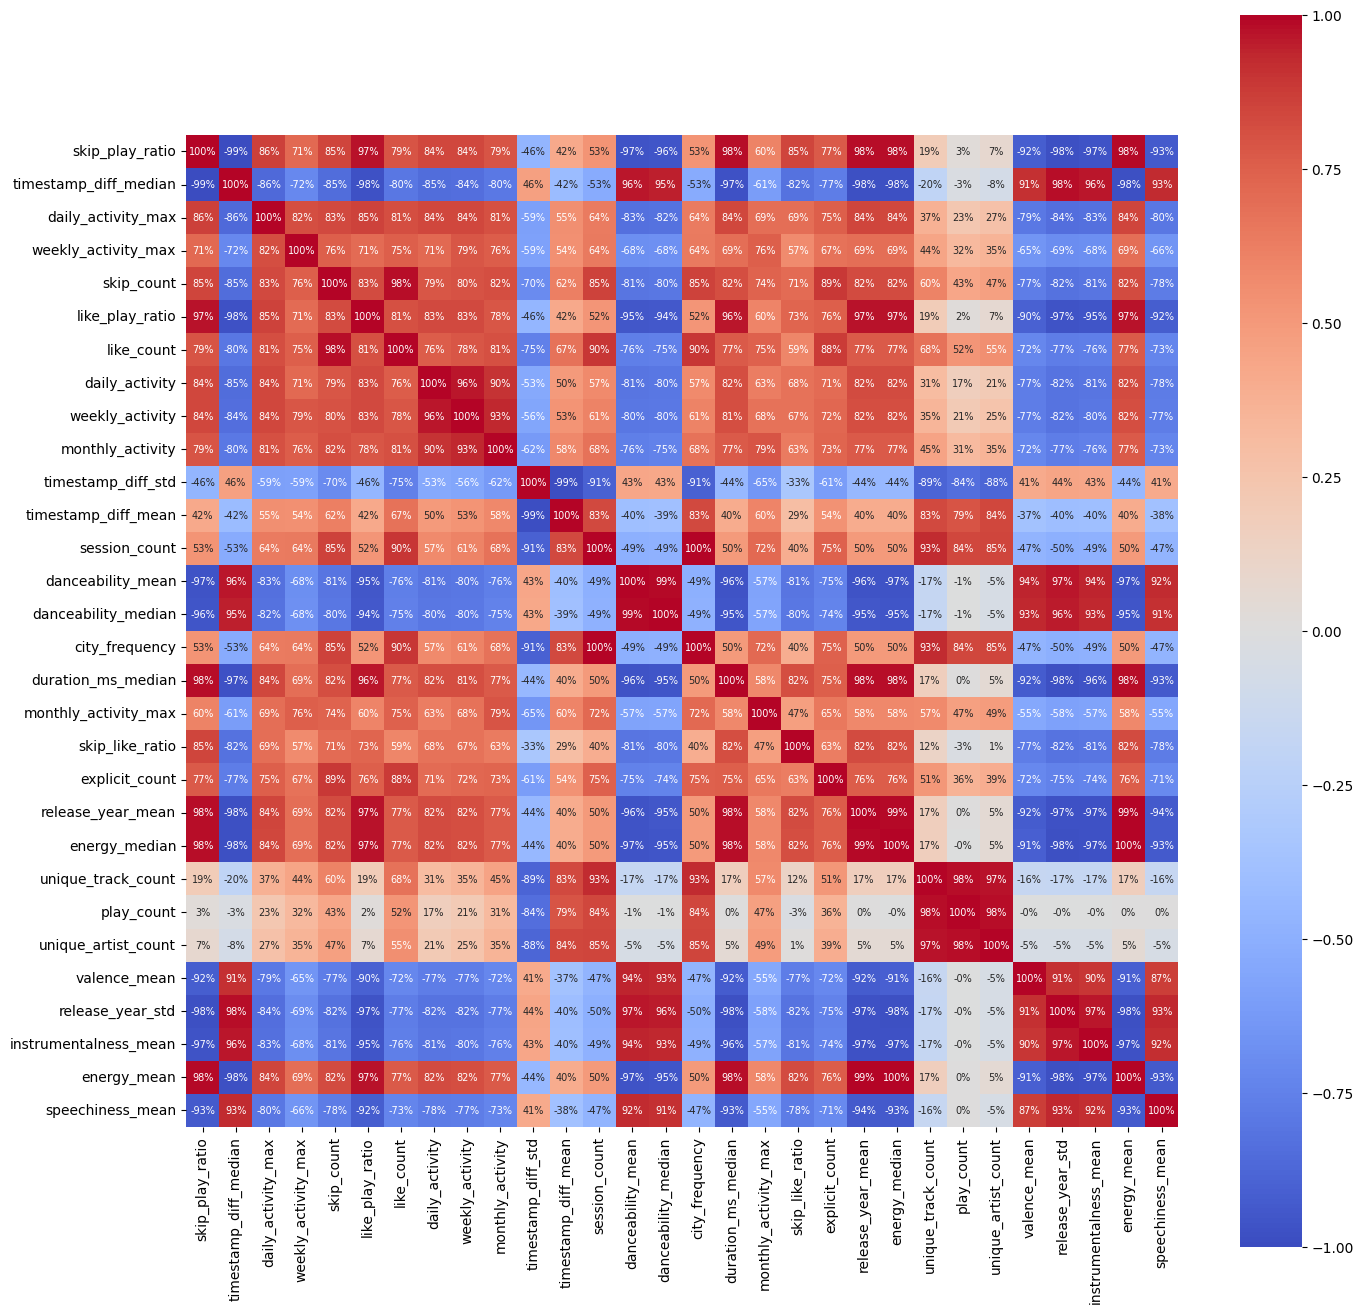

In [60]:
import seaborn as sns

continuous_fields = X_selected.select_dtypes(include=['float64', 'int64'])

print(continuous_fields.columns)

corr_matrix = continuous_fields.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, annot=True, annot_kws={'fontsize': 7}, fmt='.0%', vmin=-1, vmax=1)

array([[<Axes: title={'center': 'skip_play_ratio'}>,
        <Axes: title={'center': 'timestamp_diff_median'}>,
        <Axes: title={'center': 'daily_activity_max'}>,
        <Axes: title={'center': 'weekly_activity_max'}>,
        <Axes: title={'center': 'skip_count'}>],
       [<Axes: title={'center': 'like_play_ratio'}>,
        <Axes: title={'center': 'like_count'}>,
        <Axes: title={'center': 'daily_activity'}>,
        <Axes: title={'center': 'weekly_activity'}>,
        <Axes: title={'center': 'monthly_activity'}>],
       [<Axes: title={'center': 'timestamp_diff_std'}>,
        <Axes: title={'center': 'timestamp_diff_mean'}>,
        <Axes: title={'center': 'session_count'}>,
        <Axes: title={'center': 'danceability_mean'}>,
        <Axes: title={'center': 'danceability_median'}>],
       [<Axes: title={'center': 'city_frequency'}>,
        <Axes: title={'center': 'duration_ms_median'}>,
        <Axes: title={'center': 'monthly_activity_max'}>,
        <Axes: title={

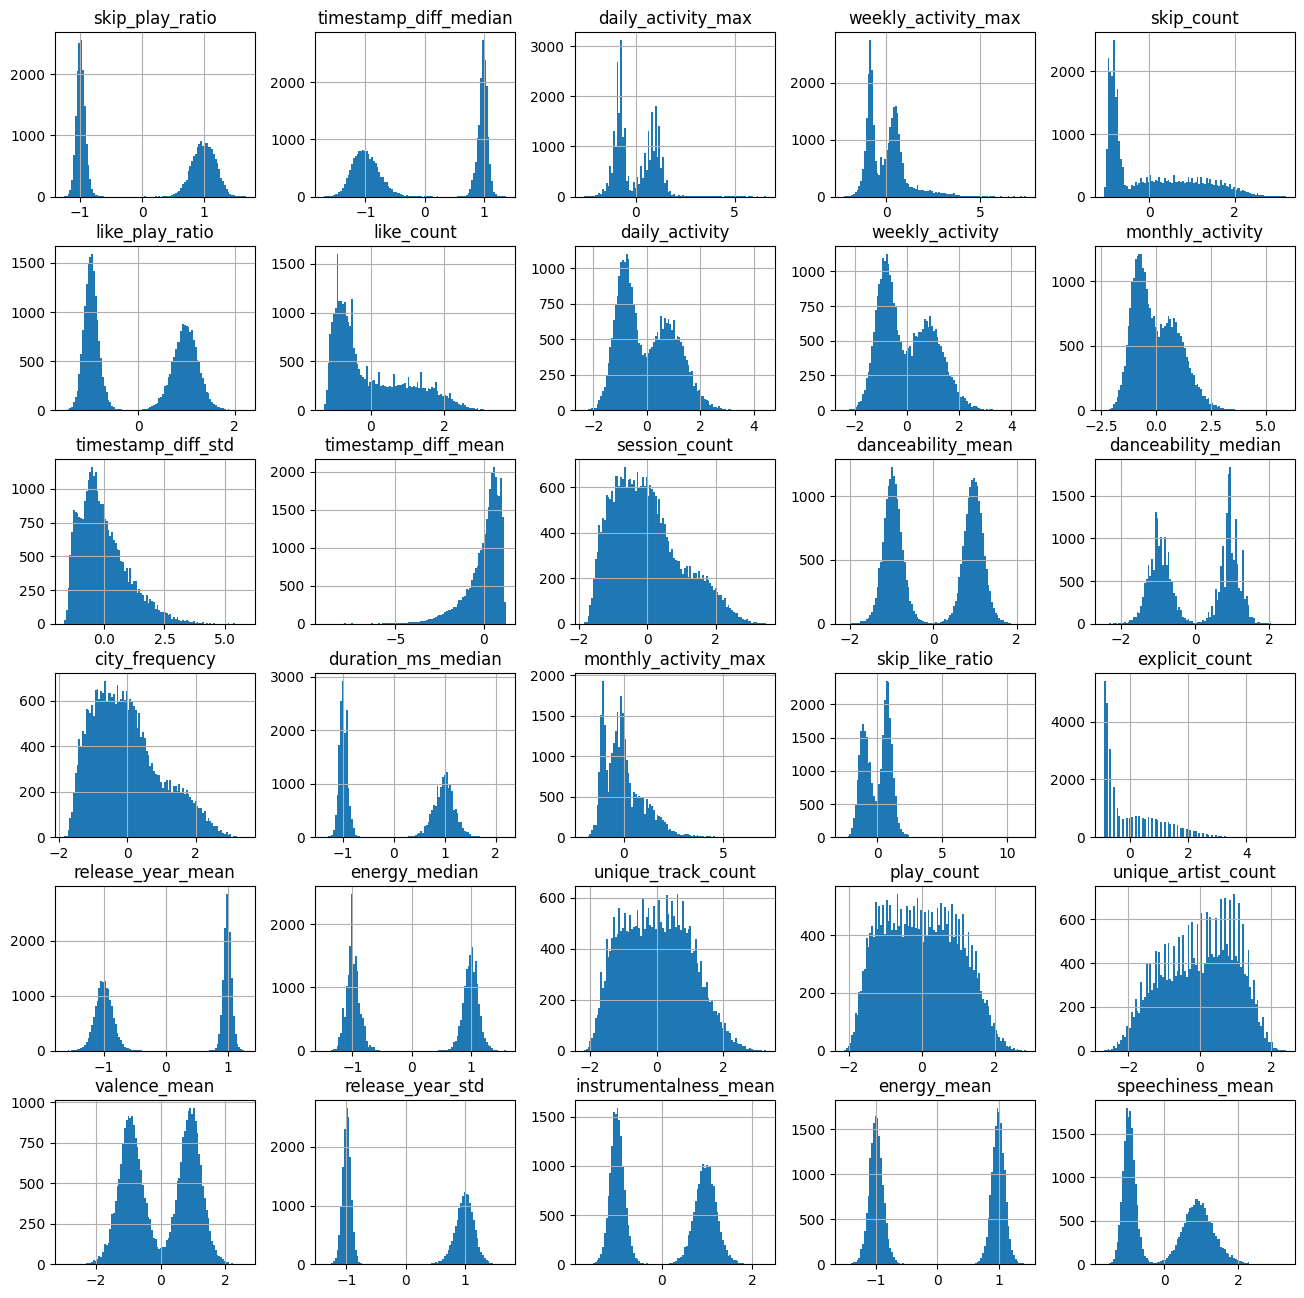

In [61]:
continuous_fields.hist(figsize=(16, 16), bins=100)

Save models

In [62]:
import joblib

model_path = os.path.join(current_dir, 'trained', 'rf_model.joblib')
model_selected_path = os.path.join(current_dir, 'trained', 'rf_selected_model.joblib')

joblib.dump(clf, model_path)
joblib.dump(clf_selected, model_selected_path)

['d:\\_prog\\Projekty\\Account-Classifier\\models\\trained\\rf_selected_model.joblib']